## BoilerPlate command

In [98]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Importing Fast AI library

In [118]:
from fastai.vision.all import *
from sklearn.metrics import classification_report
from jupyterthemes import jtplot
jtplot.style(theme="monokai", context='notebook', ticks=True, grid=False)
bs=256

## Downloading Dataset

In [100]:
path = untar_data(URLs.MNIST, dest="../data/");
path

Path('../data/mnist_png')

In [101]:
path.ls()

(#3) [Path('../data/mnist_png/models'),Path('../data/mnist_png/testing'),Path('../data/mnist_png/training')]

In [102]:
(path/'training').ls()

(#10) [Path('../data/mnist_png/training/0'),Path('../data/mnist_png/training/1'),Path('../data/mnist_png/training/2'),Path('../data/mnist_png/training/3'),Path('../data/mnist_png/training/4'),Path('../data/mnist_png/training/5'),Path('../data/mnist_png/training/6'),Path('../data/mnist_png/training/7'),Path('../data/mnist_png/training/8'),Path('../data/mnist_png/training/9')]

In [103]:
(path/'training/0').ls()[1:5]

(#4) [Path('../data/mnist_png/training/0/1000.png'),Path('../data/mnist_png/training/0/10005.png'),Path('../data/mnist_png/training/0/10010.png'),Path('../data/mnist_png/training/0/10022.png')]

## Importing Data

In [105]:
ds_tfms = aug_transforms(do_flip=False, max_rotate=15, max_zoom=1.1, max_lighting=0.2, max_warp=0.2)

In [106]:
mnist = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock), 
                  get_items=get_image_files, 
                  #splitter=RandomSplitter(0.2),
                  splitter=GrandparentSplitter(train_name='training', valid_name='testing'),
                  get_y=parent_label,
                  item_tfms=Resize(28),
                  batch_tfms=ds_tfms)
dls = mnist.dataloaders(path, bs=bs)

(#10) ['0','1','2','3','4','5','6','7','8','9']
10


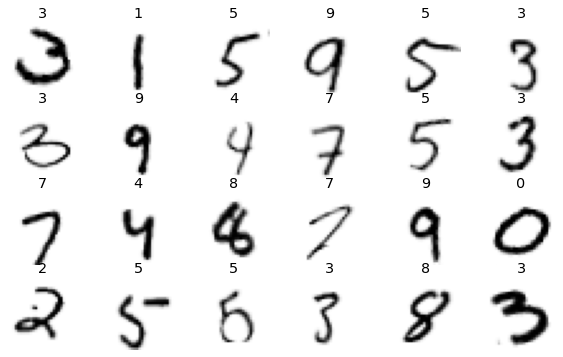

In [107]:
print(dls.vocab) ## Prints class labels
print(dls.c) ## Prints number of classes
dls.show_batch(max_n=24,figsize=(10,6)) ## Show sample data

## Defining Multilayerperceptron using Pytorch

In [108]:
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 512, bias=True) 
        self.lin2 = nn.Linear(512, 256, bias=True)
        self.lin3 = nn.Linear(256, 10, bias=True)

    def forward(self, xb):
        x = xb.view(-1,784) ## Equivalent to Flatten in Keras 28*28 -> 784
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        return self.lin3(x)

## Training the model

In [109]:
## Defining the learner
model = Mnist_NN()
mlp_learner = Learner(
    dls = dls, 
    model=model, 
    pretrained=False, 
    loss_func=F.cross_entropy, 
    model_dir=path/"models",
    metrics=accuracy)

SuggestedLRs(lr_min=0.005754399299621582, lr_steep=0.3630780577659607)

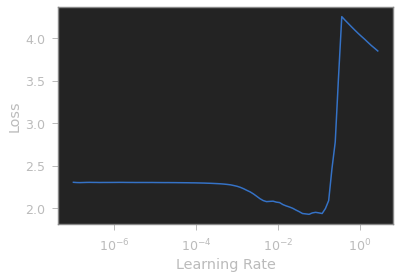

In [110]:
## Finidng Ideal learning late
mlp_learner.lr_find()

In [111]:
mlp_learner.fit_one_cycle(5,1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.379671,0.204046,0.930100,01:33
1,0.217535,0.115486,0.964300,01:19
2,0.161187,0.096609,0.969800,01:14
3,0.109536,0.056175,0.981100,01:11
4,0.087129,0.043293,0.987000,01:16


In [112]:
mlp_learner.fit_one_cycle(5,slice(1e-5,5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.107582,0.077510,0.976800,01:11
1,0.126738,0.066185,0.978600,01:13
2,0.092690,0.048585,0.984500,01:14
3,0.071606,0.041549,0.986700,01:17
4,0.067367,0.037828,0.988600,01:17


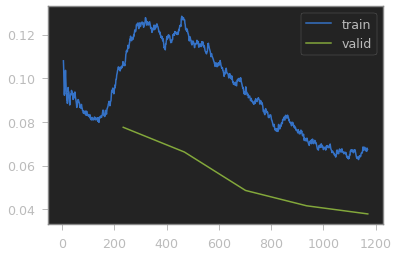

In [113]:
mlp_learner.recorder.plot_loss()

In [115]:
interp = ClassificationInterpretation.from_learner(mlp_learner)

In [146]:
print(classification_report(np.array(interp.preds).argmax(axis=1), interp.targs))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       975
           1       1.00      1.00      1.00      1136
           2       0.99      0.98      0.99      1045
           3       0.99      0.99      0.99      1006
           4       0.99      0.98      0.99       988
           5       0.99      0.98      0.99       894
           6       0.99      0.99      0.99       952
           7       0.99      0.98      0.98      1038
           8       0.98      0.99      0.99       968
           9       0.98      0.99      0.98       998

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

